In [7]:
import pandas as pd
df = pd.read_csv("Extended_Employee_Performance_and_Productivity_Data.csv")
print(df.columns)

Index(['Employee_ID', 'Department', 'Gender', 'Age', 'Job_Title', 'Hire_Date',
       'Years_At_Company', 'Education_Level', 'Performance_Score',
       'Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled',
       'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Team_Size',
       'Training_Hours', 'Promotions', 'Employee_Satisfaction_Score',
       'Resigned'],
      dtype='object')


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [11]:
# Load Data

df = pd.read_csv("Extended_Employee_Performance_and_Productivity_Data.csv")
df.columns = df.columns.str.strip()
print("Dataset shape:", df.shape)
print(df.dtypes)

Dataset shape: (100000, 20)
Employee_ID                      int64
Department                      object
Gender                          object
Age                              int64
Job_Title                       object
Hire_Date                       object
Years_At_Company                 int64
Education_Level                 object
Performance_Score                int64
Monthly_Salary                 float64
Work_Hours_Per_Week              int64
Projects_Handled                 int64
Overtime_Hours                   int64
Sick_Days                        int64
Remote_Work_Frequency            int64
Team_Size                        int64
Training_Hours                   int64
Promotions                       int64
Employee_Satisfaction_Score    float64
Resigned                          bool
dtype: object


In [16]:
# Quick EDA / sanity checks

print("\nMissing values per column:\n", df.isnull().sum())
print("\nClass distribution for 'Resinged' (if present):\n", df['Resigned'].value_counts() if 'Resigned' in df.columns else "No Resigned column")


Missing values per column:
 Employee_ID                    0
Department                     0
Gender                         0
Age                            0
Job_Title                      0
Hire_Date                      0
Years_At_Company               0
Education_Level                0
Performance_Score              0
Monthly_Salary                 0
Work_Hours_Per_Week            0
Projects_Handled               0
Overtime_Hours                 0
Sick_Days                      0
Remote_Work_Frequency          0
Team_Size                      0
Training_Hours                 0
Promotions                     0
Employee_Satisfaction_Score    0
Resigned                       0
dtype: int64

Class distribution for 'Resinged' (if present):
 Resigned
False    89990
True     10010
Name: count, dtype: int64


In [18]:
# Show a concise head
display(df.head())

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2022-01-19 08:03:05.556036,2,High School,5,6750.0,33,32,22,2,0,14,66,0,2.63,False
1,2,Finance,Male,29,Developer,2024-04-18 08:03:05.556036,0,High School,5,7500.0,34,34,13,14,100,12,61,2,1.72,False
2,3,Finance,Male,55,Specialist,2015-10-26 08:03:05.556036,8,High School,3,5850.0,37,27,6,3,50,10,1,0,3.17,False
3,4,Customer Support,Female,48,Analyst,2016-10-22 08:03:05.556036,7,Bachelor,2,4800.0,52,10,28,12,100,10,0,1,1.86,False
4,5,Engineering,Female,36,Analyst,2021-07-23 08:03:05.556036,3,Bachelor,2,4800.0,38,11,29,13,100,15,9,1,1.25,False


In [20]:
# create target : High vs Low Performance

# If performance_score is numeric
if pd.api.types.is_numeric_dtype(df['Performance_Score']):
    threshold = df['Performance_Score'].median()
    df['High_Perf'] = (df['Performance_Score'] >=threshold).astype(int)
    print(f"performance threshold (median): {threshold}")
else:
    df['High_Perf'] = df['Performance_Score'].map(lambda x: 1 if x in ['Excellent','High'] else 0)

print("Target distribution:\n",df['High_Perf'].value_counts(normalize=True))

performance threshold (median): 3.0
Target distribution:
 High_Perf
1    0.59867
0    0.40133
Name: proportion, dtype: float64


In [24]:
# Feature list & basic preprocessing plan

target = 'High_Perf'
drop_cols = ['Employee_ID', 'Hire_Date', 'Performance_Score']
x = df.drop(columns=[target] + [c for c in drop_cols if c in df.columns])
y = df[target]

# Identify numeric and categorical columns
num_cols = x.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = x.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Numaric cols:", num_cols)
print("categorical cols:",cat_cols)

Numaric cols: ['Age', 'Years_At_Company', 'Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled', 'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Team_Size', 'Training_Hours', 'Promotions', 'Employee_Satisfaction_Score']
categorical cols: ['Department', 'Gender', 'Job_Title', 'Education_Level', 'Resigned']


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Build preprocessing piplines

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer([
    ('num',num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [59]:
print(x.shape, y.shape)

(100000, 17) (100000,)


In [61]:
print("X shape:", x.shape)
print("Y shape:", y.shape)


X shape: (100000, 17)
Y shape: (100000,)


In [89]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [93]:
# Model 1 - Logistic Regression

log_reg_model = Pipeline([
    ("preprocess",preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_model.fit(x_train, y_train)
y_pred_lr = log_reg_model.predict(x_test)

print("Logistic Regression Accuracy:",accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8027
           1       1.00      1.00      1.00     11973

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [97]:
# Model 2 - Decision Tree

dt_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
])

dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)

print("Decisiom Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decisiom Tree Accuracy: 0.8289
              precision    recall  f1-score   support

           0       0.90      0.65      0.75      8027
           1       0.80      0.95      0.87     11973

    accuracy                           0.83     20000
   macro avg       0.85      0.80      0.81     20000
weighted avg       0.84      0.83      0.82     20000



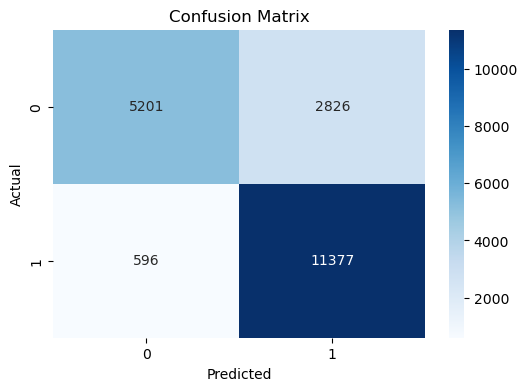

In [107]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_pred = y_pred_dt  

cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


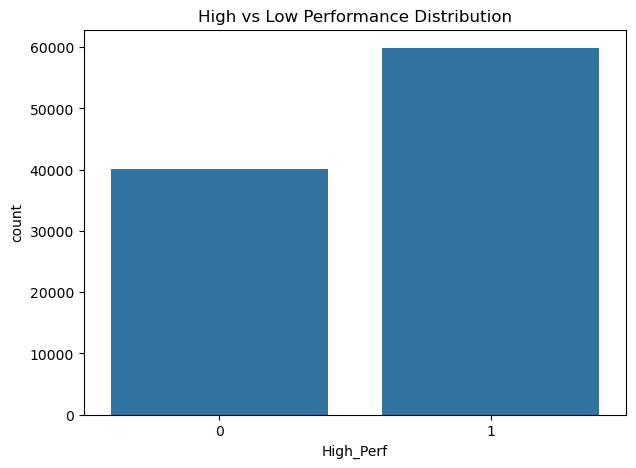

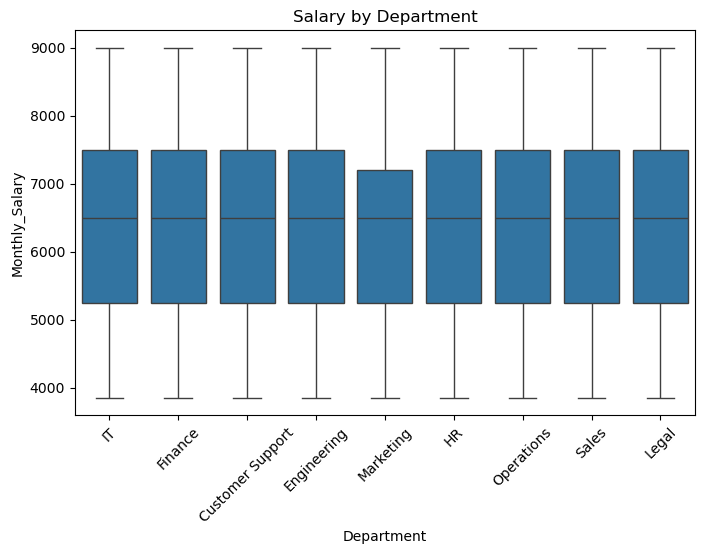

F:\New folder\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


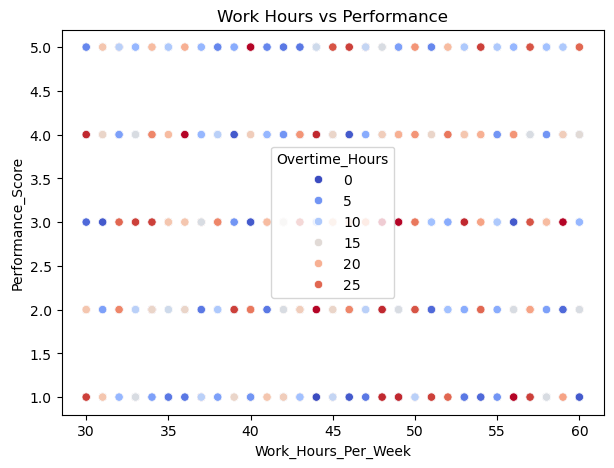

In [109]:
# Visualizations

plt.figure(figsize=(7,5))
sns.countplot(x=df["High_Perf"])
plt.title("High vs Low Performance Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Department"], y=df["Monthly_Salary"])
plt.title("Salary by Department")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x=df["Work_Hours_Per_Week"], 
                y=df["Performance_Score"], 
                hue=df["Overtime_Hours"], 
                palette="coolwarm")
plt.title("Work Hours vs Performance")
plt.show()


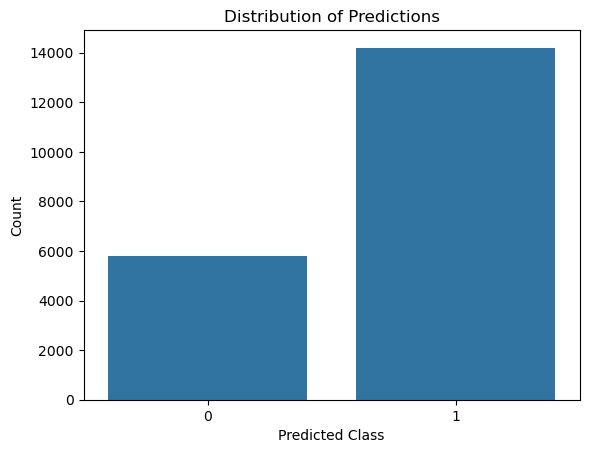

In [117]:
# Distribution of Predictions

sns.countplot(x=y_pred_dt)
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()


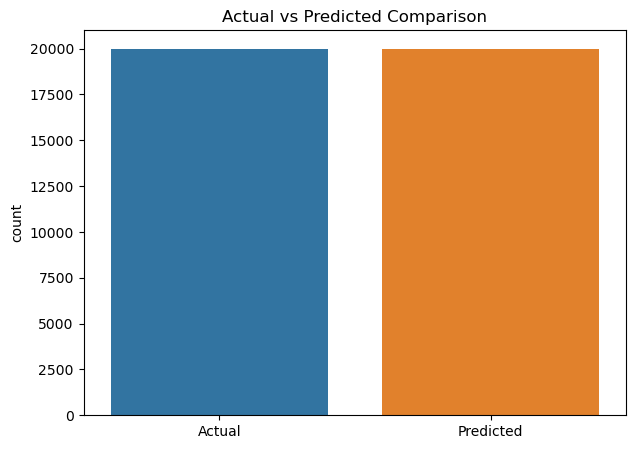

In [119]:
# Actual vs Predicted

comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_dt})

plt.figure(figsize=(7,5))
sns.countplot(data=comparison)
plt.title("Actual vs Predicted Comparison")
plt.show()
